## Завантаження даних

Для початку, давайте завантажимо дані з файлу csv.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !ls 'drive/MyDrive/ML Intensive from 0 to Hero'

'1. EDA. Лінійна регресія. Solution.ipynb'   medical-charges.csv


In [ ]:
# file_name = 'drive/MyDrive/ML Intensive from 0 to Hero/medical-charges.csv'

In [ ]:
# medical_df = pd.read_csv(file_name)

In [ ]:
medical_df = pd.read_csv('medical-charges.csv')

## Лінійна регресія за допомогою однієї ознаки

Ми вже знаємо, що стовпці "курець" та "вік" мають найсильнішу кореляцію з "витратами". Спробуємо знайти спосіб оцінки значення "витрат" за допомогою значення "віку" для некурців. Спочатку створимо фрейм даних, який містить лише дані для некурців.

In [ ]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Далі, давайте візуалізуємо взаємозв'язок між "віком" та "витратами"

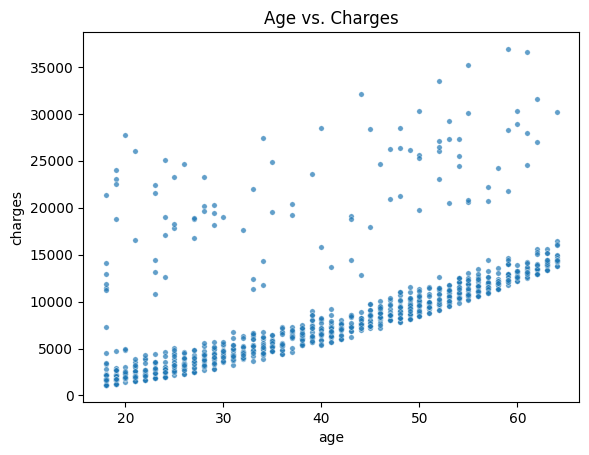

In [ ]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

Окрім декількох винятків, точки, здається, формують лінію. Ми спробуємо "підібрати" лінію, використовуючи ці точки, і використовувати лінію для прогнозування вартості за віком. Лінія на координатах X&Y має наступну формулу:

$y = wx + b$

Лінія характеризується двома числами: $w$ (називається "нахил") і $b$ (називається "зміщення").

### Модель

У вищенаведеному випадку вісь x показує `age`, а вісь y показує `charges`. Таким чином, ми припускаємо наступну залежність між ними:

$charges = w \times age + b$

Ми спробуємо визначити $w$ і $b$ для лінії, яка найкраще підходить для даних.

* Цей метод називається _лінійною регресією_, і ми називаємо вищенаведене рівняння _моделлю лінійної регресії_, оскільки воно моделює залежність між "віком" і "вартістю" як пряму лінію.

* Числа $w$ і $b$ називаються _параметрами_ або _вагами_ моделі.

* Значення в стовпці "вік" набору даних називаються _вхідними даними_ моделі, а значення в стовпці `charges` називаються "цільовими" (targets).

Давайте визначимо допоміжну функцію `estimate_charges`, щоб обчислити $charges$, з урахуванням $age$, $w$ і $b$.

In [ ]:
def estimate_charges(age, w, b):
    return w * age + b

Функція `estimate_charges` є нашою першою _моделлю_.

Давайте _здогадаємося_ щодо значень для $w$ та $b$ і використаємо їх для оцінки вартості послуг.

In [ ]:
w = 50
b = 100

In [ ]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w, b)

Ми можемо відобразити оцінені витрати за допомогою лінійного графіка.

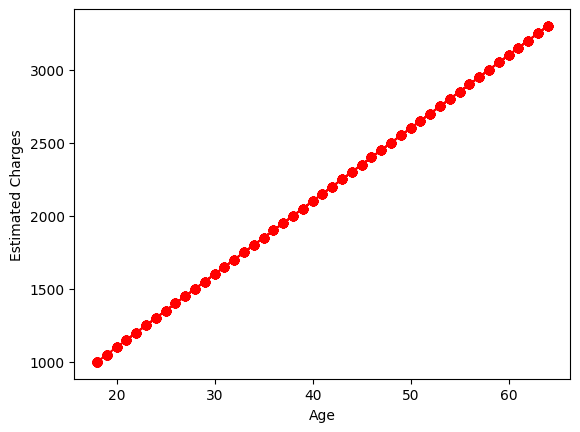

In [ ]:
plt.plot(ages, estimated_charges, 'r-o');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

Як і очікувалося, точки лежать на прямій лінії.

Ми можемо накласти цю лінію на реальні дані, щоб побачити, наскільки добре наша _модель_ відповідає _даним_.

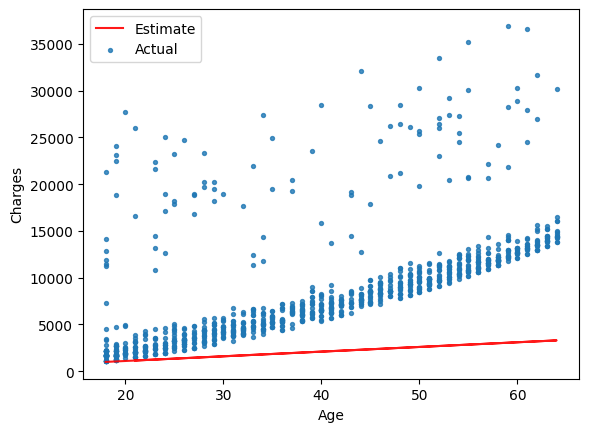

In [ ]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8, alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);

Очевидно, наші оцінки досить погані, і лінія не "підходить" до даних. Однак, ми можемо спробувати різні значення $w$ та $b$, щоб перемістити лінію. Давайте визначимо допоміжну функцію `try_parameters`, яка приймає `w` та `b` як вхідні дані та створює вищезазначений графік.

In [ ]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges

    estimated_charges = estimate_charges(ages, w, b)

    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

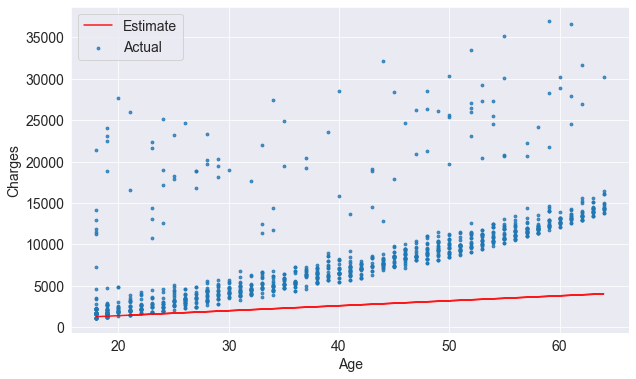

In [ ]:
try_parameters(60, 200)

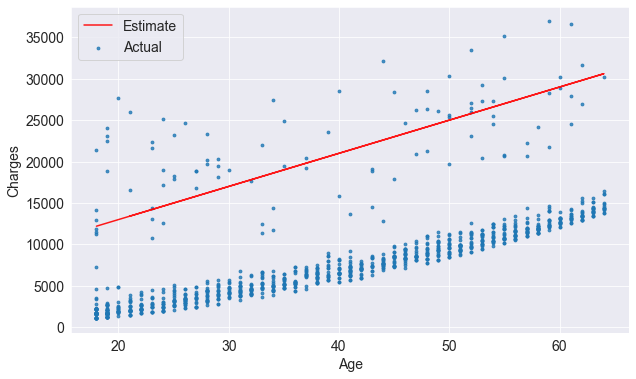

In [ ]:
try_parameters(400, 5000)

> **ВПРАВА 1**: Спробуйте різні значення $w$ та $b$, щоб знайти лінію, яка найкраще підходить для даних. Який ефект від зміни значення $w$? Який ефект від зміни $b$?

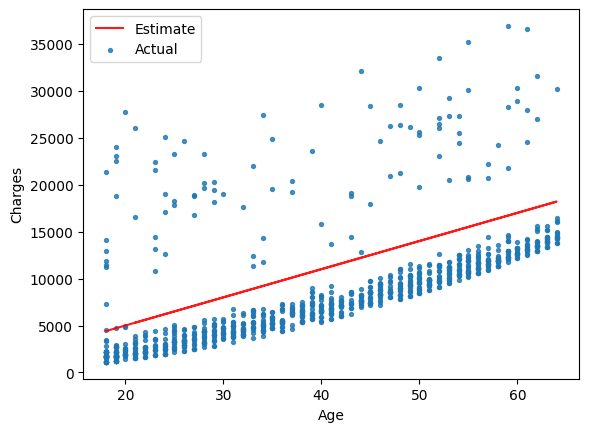

In [ ]:
try_parameters(300, -1000)

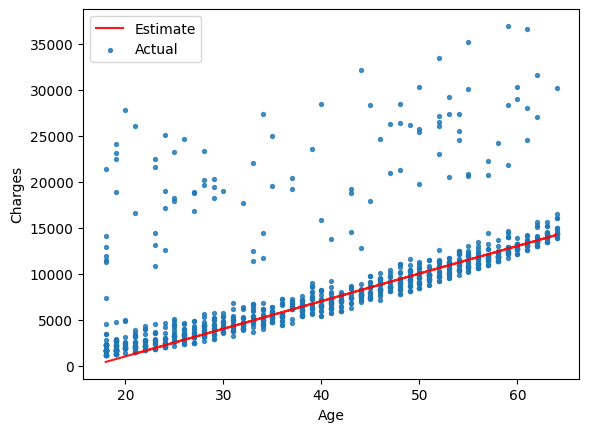

In [ ]:
try_parameters(300, -5000)

Відповідь: зміна w - зміна нахилу прямої, зміна b - зміщаення вверх або вниз прямої

Коли ми змінюємо значення $w$ та $b$ вручну, намагаючись візуально наблизити лінію до точок, ми _вчимося_ приблизному відношенню між "віком" та "витратами".

Чи не було б чудово, якби комп'ютер міг спробувати кілька різних значень `w` та `b` та _вивчити_ відношення між "віком" та "витратами"? Щоб зробити це, нам потрібно вирішити кілька проблем:

1. Нам потрібен спосіб чисельно виміряти, наскільки добре лінія підходить до точок.

2. Після того, як "міра відповідності" була обчислена, нам потрібен спосіб змінити `w` та `b`, щоб покращити відповідність.

Якщо ми зможемо вирішити вищезазначені проблеми, комп'ютер повинен мати змогу визначити `w` та `b` для лінії найкращого відповідності, починаючи з випадкового припущення. Автоматичне визначення параметрів моделі за даними і зазначеними правилами і називається "машинним навчанням".

### Функція втрат/вартості

Ми можемо порівняти прогнози нашої моделі з фактичними цілями за допомогою наступного методу:

* Розрахувати різницю між цілями та прогнозами (ця різниця називається "залишком" - residual)
* Піднести до квадрату всі елементи матриці різниць, щоб усунути від'ємні значення.
* Розрахувати середнє значення елементів у результуючій матриці.
* Взяти квадратний корінь з результату

Результатом є одне число, відоме як **коренева середньоквадратична помилка** (RMSE - root mean squared error). Вищенаведений опис можна виразити математично наступним чином:

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Геометрично, залишки можна візуалізувати наступним чином:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Давайте визначимо функцію для обчислення RMSE.

In [ ]:
!pip install numpy --quiet

In [ ]:
import numpy as np

In [ ]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

Давайте обчислимо RMSE для нашої моделі з набором вибіркових ваг

In [ ]:
w = 50
b = 100

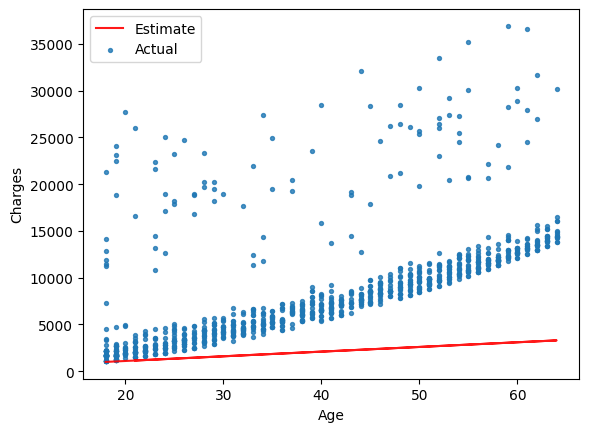

In [ ]:
try_parameters(w, b)

In [ ]:
targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)

In [ ]:
rmse(targets, predicted)

8461.949562575493

Ось як ми можемо інтерпретувати вищезазначене число: *В середньому, кожен елемент у прогнозі відрізняється від фактичної цілі на \$8461*.

Результат називається *втратою*, оскільки він вказує на те, наскільки погано модель прогнозує цільові змінні. Він представляє втрату інформації в моделі: чим нижче втрата, тим краща модель.

Давайте оновимо функцію `try_parameters`, щоб також відображати втрату.

In [ ]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)

    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8, alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);

    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.949562575493


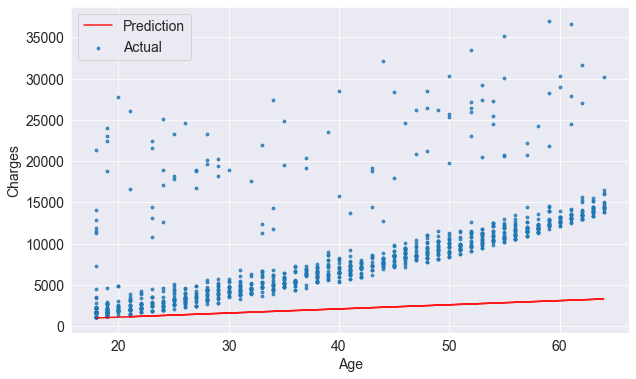

In [ ]:
try_parameters(50, 100)

> **ВПРАВА 2**: Спробуйте різні значення $w$ та $b$, щоб мінімізувати втрати RMSE. Яке найнижче значення втрат ви зможете досягти? Опишіть як би ви таким методом спроб і помилок шукали найкращі значення $w$ та $b$?

RMSE Loss:  4956.973980899423


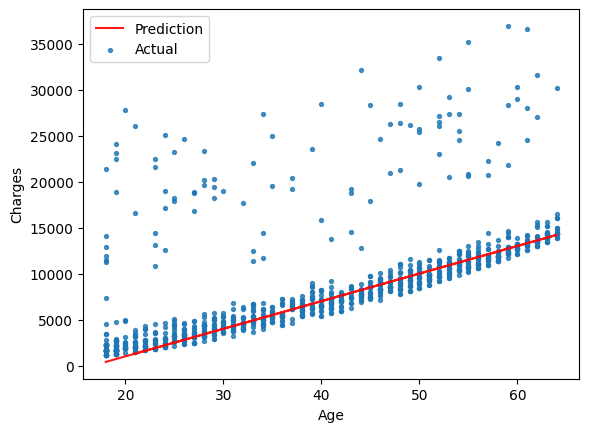

In [ ]:
try_parameters(300, -5000)

Стратегія була - спочатку знайти оптимальний нахил, а потім знайти зміщення. В мене вийшло це зробити за біля 5 ітерацій.

### Оптимізатор

Далі нам потрібна стратегія зміни ваг `w` та `b` для зменшення втрат і поліпшення "підгонки" лінії до даних.

* Метод найменших квадратів: https://www.youtube.com/watch?v=szXbuO3bVRk (краще для менших наборів даних)
* Стохастичний градієнтний спуск: https://www.youtube.com/watch?v=sDv4f4s2SB8 (краще для більших наборів даних)

Обидва ці методи мають однакову мету: мінімізувати втрати, однак, метод найменших квадратів безпосередньо обчислює найкращі значення для `w` та `b`, використовуючи операції з матрицями, тоді як градієнтний спуск використовує ітеративний підхід, починаючи з випадкових значень `w` та `b` і поступово поліпшуючи їх за допомогою похідних.

Ось візуалізація того, як працює градієнтний спуск:

![](https://miro.medium.com/max/1728/1*NO-YvpHHadk5lLxtg4Gfrw.gif)

Чи не схоже це на нашу власну стратегію поступового наближення лінії до точок?

### Лінійна регресія за допомогою Scikit-learn

На практиці вам ніколи не доведеться самостійно реалізовувати жоден з вищезазначених методів. Ви можете використовувати бібліотеку, таку як `scikit-learn`, щоб зробити це за вас.

In [ ]:
!pip install scikit-learn --quiet

Давайте використовуємо клас `LinearRegression` з `scikit-learn`, щоб знайти найкращу лінію для `age` проти `charges` за допомогою методу Ordinary Least Squares.

In [ ]:
from sklearn.linear_model import LinearRegression

Спочатку ми створюємо новий об'єкт моделі.

In [ ]:
model = LinearRegression()

Далі ми можемо використати метод `fit` моделі, щоб знайти найкращу лінію, що відповідає вхідним даним та цілям.

In [ ]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data.
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample.
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : object
        Fitted Estimator.



Зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку.

In [ ]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.charges
print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


Давайте налаштуємо модель під дані.

In [ ]:
model.fit(inputs, targets)

LinearRegression()

Ми можемо робити прогнози за допомогою моделі. Спробуймо прогнозувати витрати для віків 23, 37 та 61.

In [ ]:
model.predict(np.array([[23],
                        [37],
                        [61]]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([ 4055.30443855,  7796.78921819, 14210.76312614])

Чи здаються вам ці значення розумними? Порівняйте їх з діаграмою розсіювання вище.

Давайте обчислимо прогнози для всього набору вхідних даних.

In [ ]:
predictions = model.predict(inputs)

In [ ]:
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

Давайте обчислимо втрату RMSE для оцінки моделі.

In [ ]:
rmse(targets, predictions)

4662.505766636395

Схоже, що наш прогноз відрізняється на $4000 в середньому, що не є занадто поганим, враховуючи те, що є декілька викидів.

Параметри моделі зберігаються в властивостях `coef_` та `intercept_`.

In [ ]:
# w
model.coef_

array([267.24891283])

In [ ]:
# b
model.intercept_

-2091.4205565650864

Чи є ці параметри близькими до ваших найкращих припущень?

Давайте візуалізуємо лінію, створену за допомогою вищезазначених параметрів.

RMSE Loss:  4662.505766636395


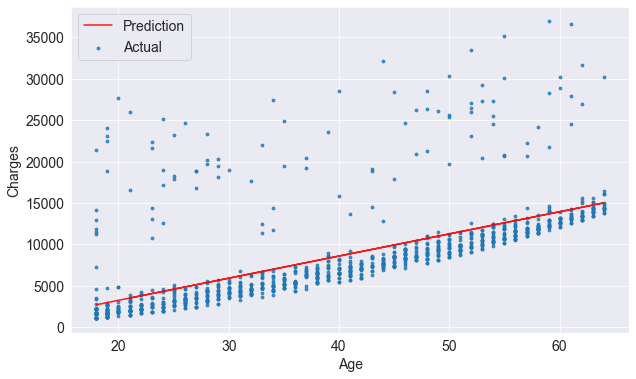

In [ ]:
try_parameters(model.coef_, model.intercept_)

Справді, лінія досить близько до точок. Вона трохи вище за кластер точок, тому що вона також намагається врахувати викиди.

> **ВПРАВА 3**: Використовуйте клас [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) з `scikit-learn` для тренування моделі за допомогою техніки стохастичного градієнтного спуску. Зробіть прогнози та обчисліть втрати. Бачите якісь відмінності в результаті?

In [ ]:
from sklearn.linear_model import SGDRegressor

# Створимо об'єкт моделі
sgd_model = SGDRegressor()

# Навчаємо модель
sgd_model.fit(inputs, targets)

# Робимо прогнози
sgd_predictions = sgd_model.predict(inputs)

# Параметри моделі
w_sgd = sgd_model.coef_
b_sgd = sgd_model.intercept_

print("Коефіцієнт:", w_sgd)
print("Перетин з віссю y:", b_sgd)

Коефіцієнт: [309.39712486]
Перетин з віссю y: [-5542.04441387]


RMSE Loss:  5029.63568116287


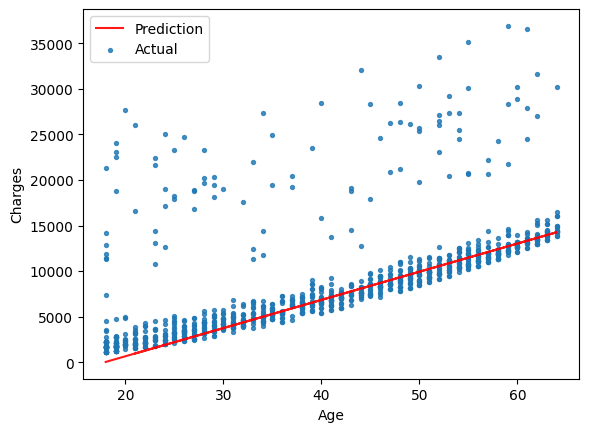

In [ ]:
try_parameters(w_sgd, b_sgd)

Відповідь: Візуалізація показує, що лінія прогнозу знаходиться гарно підходить під кластер точок. Однак, RMSE для моделі LinearRegression дещо нижче (4662.51) порівняно з SGDRegressor (5029.63). Це означає, що модель LinearRegression трохи точніше прогнозує значення у нашому випадку.

> **ВПРАВА 4**: Повторіть кроки цього розділу, щоб навчити модель лінійної регресії оцінювати `charges` для курців. Візуалізуйте цільові значення та прогнози, та обчисліть втрати.

In [ ]:
# Визначаємо наш датафрейм для курців, інпути та таргети
smoker_df = medical_df[medical_df.smoker == 'yes']

inputs_smoker = smoker_df[['age']]
targets_smoker = smoker_df.charges

print('inputs_smoker.shape :', inputs_smoker.shape)
print('targets_smoker.shape :', targets_smoker.shape)

inputs_smoker.shape : (274, 1)
targets_smoker.shape : (274,)


In [ ]:
# Навчаємо модель лінійної регресії
model_smoker = LinearRegression()
model_smoker.fit(inputs_smoker, targets_smoker)

LinearRegression()

In [ ]:
# Робимо прогнози
predictions_smoker = model_smoker.predict(inputs_smoker)

# Розраховуємо помилки
rmse_smoker = np.sqrt(mean_squared_error(targets_smoker, predictions_smoker))

print("RMSE для курців:", rmse_smoker)

RMSE для курців: 10711.00334810241


In [ ]:
w_smoker = model.coef_
b_smoker = model.intercept_

print("Коефіцієнти для курців:", w_smoker)
print("Перетин з віссю y для курців:", b_smoker)

Коефіцієнти для курців: [267.24891283]
Перетин з віссю y для курців: -2091.4205565650864


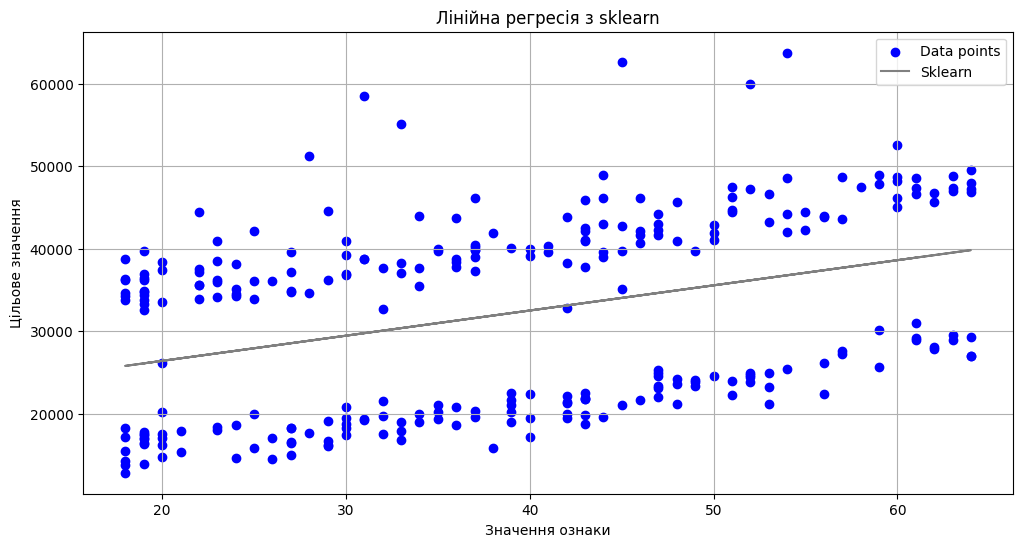

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(smoker_df['age'], smoker_df['charges'], color='blue', label='Data points')
plt.plot(smoker_df['age'], predictions_smoker, color='grey', label='Sklearn')
plt.title('Лінійна регресія з sklearn')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

### Машинне навчання

Вітаємо, ви щойно навчили свою першу _модель машинного навчання!_ Машинне навчання - це просто процес обчислення найкращих параметрів для моделювання взаємозвʼязку між деякою ознакою та цілями.

Кожна проблема машинного навчання має три компоненти:

1. **Модель**

2. **Функція втрат (Cost/Loss function)**

3. **Оптимізатор**


<img src="https://i.imgur.com/oiGQFJ9.png" width="480">

Як ми бачили вище, для тренування моделі машинного навчання за допомогою `scikit-learn` потрібно всього кілька рядків коду.

In [ ]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.505766636395


## Лінійна регресія з використанням кількох характеристик

До цього моменту ми використовували лише характеристику "вік" для оцінки "витрат". Додавання іншої характеристики, наприклад "індекс маси тіла", є досить простим. Ми просто припускаємо наступну залежність:

$charges = w_1 \times age + w_2 \times bmi + b$

Нам потрібно змінити лише один рядок коду, щоб включити індекс маси тіла.

In [ ]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.3128354612945


Як ви можете бачити, з додаванням ІМТ не вдається значно зменшити втрати, оскільки ІМТ має дуже слабку кореляцію з витратами, особливо для некурців.

In [ ]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.0840365431283327

In [ ]:
fig = px.scatter(non_smoker_df, x='bmi', y='charges', title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Ми також можемо візуалізувати взаємозв'язок між усіма трьома змінними "вік", "індекс маси тіла" та "витрати" за допомогою 3D діаграми розсіювання.

In [ ]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='charges')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

Ви можете побачити, що інтерпретувати 3D діаграму розсіювання складніше, ніж 2D діаграму розсіювання. Як тільки ми додаємо більше характеристик, стає неможливим візуалізувати всі характеристики одночасно, через що ми використовуємо такі міри, як кореляція та втрати.

Також давайте перевіримо параметри моделі.

In [ ]:
model.coef_, model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488727)

Очевидно, ІМТ має набагато меншу вагу, і ви можете бачити чому. Він робить невеликий внесок, і навіть це, швидше за все, випадково. Це важливо мати на увазі: **ви не зможете знайти зв'язок, якого не існує, незалежно від того, яку техніку машинного навчання або алгоритм оптимізації ви застосовуєте.**

> **ВПРАВА 5**: Навчіть модель лінійної регресії оцінювати витрати, використовуючи лише BMI. Чи очікуєте ви, що вона буде кращою або гіршою за раніше навчені моделі?

In [ ]:
# Підготовка вхідних та цільових значень для некурців
inputs_bmi = non_smoker_df[['bmi']]
targets_bmi = non_smoker_df['charges']

print('inputs_smoker.shape :', inputs_bmi.shape)
print('targets_smoker.shape :', targets_bmi.shape)

inputs_smoker.shape : (1064, 1)
targets_smoker.shape : (1064,)


In [ ]:
# Навчаємо модель
bmi_model = LinearRegression().fit(inputs_bmi, targets_bmi)

# Робимо прогнози
predictions_bmi = bmi_model.predict(inputs_bmi)

print("RMSE для моделі, яка використовує тільки BMI:", rmse(targets_bmi, predictions_bmi))

RMSE для моделі, яка використовує тільки BMI: 5969.772531913293


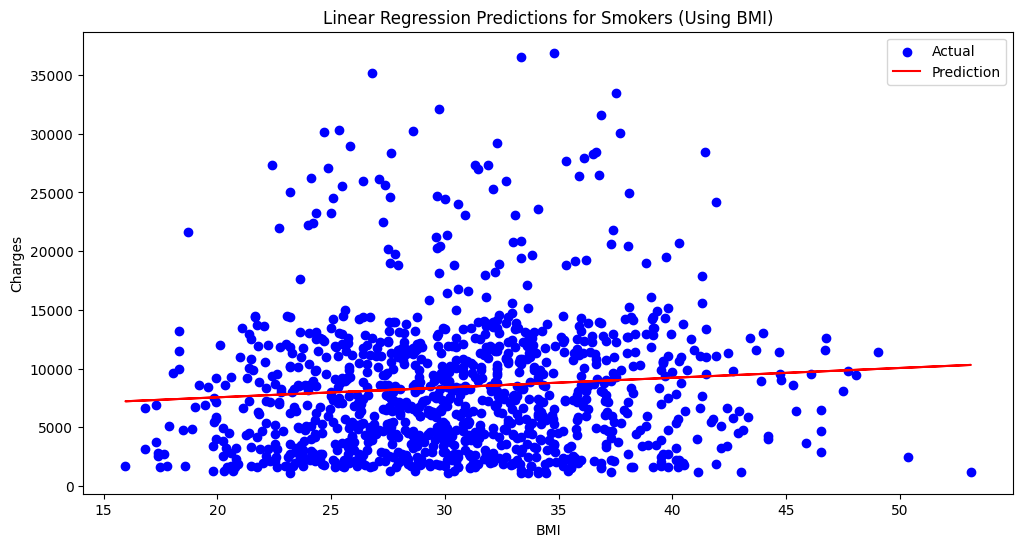

In [ ]:
# Візуалізуємо результати
plt.figure(figsize=(12, 6))
plt.scatter(inputs_bmi, targets_bmi, color='blue', label='Actual')
plt.plot(inputs_bmi, predictions_bmi, color='red', label='Prediction')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()
plt.title('Linear Regression Predictions for Smokers (Using BMI)')
plt.show()

Як і було очікувано, прогнозування вартості лише на основі BMI є гіршим, ніж на попередніх моделях. Графік показує нам, наскільки добре модель, що використовує лише BMI, співпадає з фактичними даними.

Давайте зробимо ще один крок вперед і додамо останню числову колонку: "діти", яка, здається, має деяку кореляцію з "витратами".

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + b$

In [ ]:
non_smoker_df.charges.corr(non_smoker_df.children)

0.13892870453542192

In [ ]:
fig = px.strip(non_smoker_df, x='children', y='charges', title= "Children vs. Charges")
fig.update_traces(marker_size=4, marker_opacity=0.7)
fig.show()

In [ ]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi', 'children']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4608.470405038247


Ще раз, ми не бачимо великого зменшення втрат, хоча воно більше, ніж у випадку з ІМТ.

> **ВПРАВА 6**: Повторіть кроки цього підрозділу (створення моделей прогнозування на кількох характеристиках), щоб навчити модель лінійної регресії оцінювати медичні витрати для курців. Візуалізуйте цільові значення та прогнози, та обчисліть loss.

In [ ]:
# Підготовка вхідних та цільових значень для некурців
inputs, targets = smoker_df[['age', 'bmi', 'children']], smoker_df['charges']

# Створюємо та навчаємо модель
model = LinearRegression().fit(inputs, targets)

# Робимо прогнози
predictions = model.predict(inputs)

# Рахуємо помилки
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5718.202480524154


> **ВПРАВА 7**: Повторіть кроки цього підрозділу, щоб навчити модель лінійної регресії оцінювати медичні витрати для всіх клієнтів. Візуалізуйте цілі та прогнози, та обчисліть loss. Чи втрати нижчі чи вищі?

In [ ]:
# Підготовка вхідних та цільових значень для всіх клієнтів
inputs, targets = medical_df[['age', 'bmi', 'children']], medical_df['charges']

# Створюємо та навчаємо модель
model = LinearRegression().fit(inputs, targets)

# Робимо прогнози
predictions = model.predict(inputs)

# Рахуємо помилки
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 11355.317901125973


Модель для курців має значно нижчі втрати (5718.20) порівняно з моделлю для всіх клієнтів, яка має втрати 11355.32. Це може вказувати на те, що прогнозування витрат для курців є більш точним і передбачуваним у порівнянні з прогнозуванням для всіх клієнтів, включаючи як курців, так і некурців.

## Використання категоріальних ознак для машинного навчання

До цього моменту ми використовували лише числові стовпці, оскільки ми можемо виконувати обчислення лише з числами. Якщо б ми могли використовувати категоріальні стовпці, як "курець", ми могли б навчити єдину модель для всього набору даних.

Щоб використовувати категоріальні стовпці, нам просто потрібно перетворити їх на числа. Існує три поширені техніки для цього:

1. Якщо категоріальний стовпець має лише дві категорії (його називають бінарною категорією), то ми можемо замінити їх значення на 0 і 1.
2. Якщо категоріальний стовпець має більше ніж 2 категорії, ми можемо виконати [one-hot кодування](https://www.geeksforgeeks.org/ml-one-hot-encoding/), тобто створити новий стовпець для кожної категорії з 1 та 0.
3. Якщо категорії мають природний порядок (наприклад, холодно, нейтрально, тепло, гаряче), то вони можуть бути перетворені на числа (наприклад, 1, 2, 3, 4), зберігаючи порядок. Таке кодування називається ordinal encoding.

## Бінарні категорії

Категорія "курець" має лише два значення "так" та "ні". Створимо нову колонку "smoker_code", де 0 відповідає "ні", а 1 - "так".

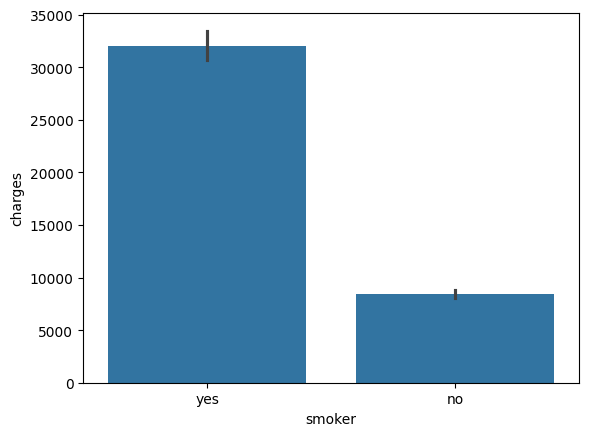

In [ ]:
sns.barplot(data=medical_df, x='smoker', y='charges');

In [ ]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [ ]:
medical_df.charges.corr(medical_df.smoker_code)

0.787251430498478

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0
1334,18,female,31.920,0,no,northeast,2205.98080,0
1335,18,female,36.850,0,no,southeast,1629.83350,0
1336,21,female,25.800,0,no,southwest,2007.94500,0


Тепер ми можемо використовувати стовпець `smoker_df` для лінійної регресії.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + b$

In [ ]:
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code']], medical_df['charges']

model = LinearRegression().fit(inputs, targets)

predictions = model.predict(inputs)

loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.439217188081


Втрати зменшилися з `11355` до `6056`, майже на 50%! Це важливий урок: ніколи не ігноруйте категоріальні дані.

Спробуємо додати стовпець "стать".

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + b$

<AxesSubplot:xlabel='sex', ylabel='charges'>

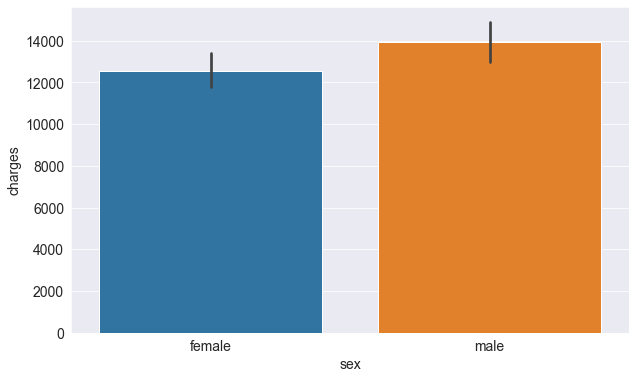

In [ ]:
sns.barplot(data=medical_df, x='sex', y='charges')

In [ ]:
sex_codes = {'female': 0, 'male': 1}

In [ ]:
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [ ]:
medical_df.charges.corr(medical_df.sex_code)

0.057292062202025484

In [ ]:
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code', 'sex_code']], medical_df['charges']

model = LinearRegression().fit(inputs, targets)

predictions = model.predict(inputs)

loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.100708754546


Ця колонка не надто повпливала на модель.

### One-hot кодування

Стовпець "region" містить 4 значення, тому нам потрібно використовувати one-hot encoding та створити новий стовпець для кожного регіону.

![](https://i.imgur.com/n8GuiOO.png)

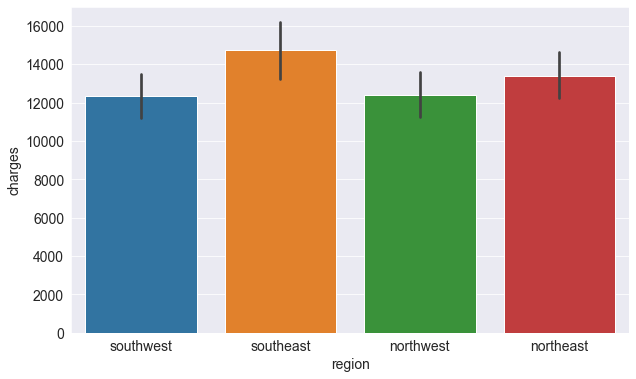

In [ ]:
sns.barplot(data=medical_df, x='region', y='charges');

In [ ]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [ ]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [ ]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


Давайте включимо стовпці регіону до нашої моделі лінійної регресії.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [ ]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


Ще раз, це призводить до досить невеликого зменшення втрат.

> **ВПРАВА 8**: Чи дві окремі моделі лінійної регресії, одна для курців і одна для некурців, кращі, ніж одна модель лінійної регресії? Чому на ваш погляд так або ні? Спробуйте це і подивіться, чи можете ви обгрунтувати свою відповідь даними.

Модель для курців:

In [ ]:
smoker_df = medical_df[medical_df.smoker == 'yes']

In [ ]:
input_cols = ['age', 'bmi', 'children','smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs_smoker = smoker_df[input_cols]
targets_smoker = smoker_df['charges']

# Create and train the model
model_smoker = LinearRegression().fit(inputs_smoker, targets_smoker)

# Generate predictions
predictions_smoker = model.predict(inputs_smoker)

# Compute loss to evalute the model
loss_smoker = rmse(targets_smoker, predictions_smoker)
print('Loss for smoker_df:', loss_smoker)

Loss for smoker_df: 9087.375033799271


Модель для НЕкурців:

In [ ]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [ ]:
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs_non_smoker = non_smoker_df[input_cols]
targets_non_smoker = non_smoker_df['charges']

# Create and train the model
model_non_smoker = LinearRegression().fit(inputs_non_smoker, targets_non_smoker)

# Generate predictions
predictions_non_smoker = model.predict(inputs_non_smoker)

# Compute loss to evalute the model
loss_smoker = rmse(targets_non_smoker, predictions_non_smoker)
print('Loss for non_smoker_df:', loss_smoker)

Loss for non_smoker_df: 4963.447912589678


Модель для всіх клієнтів:

In [ ]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss for all df:', loss)

Loss for all df: 6041.6796511744515


Отже, ми створили окремі моделі лінійної регресії для курців та некурців, а також одну загальну модель для всіх клієнтів.
- Модель для некурців має найнижчу втрату (4963.45), що вказує на те, що вона найкраще передбачає медичні витрати для цієї групи.

- Модель для курців має найвищу втрату (9087.38), що вказує на те, що прогнозування медичних витрат для курців є більш складним.

- Загальна модель для всіх клієнтів має втрату 6041.68, яка є середньою між моделями для курців та некурців.

Окремі моделі для курців та некурців дійсно показують кращі результати порівняно з загальною моделлю для всіх клієнтів. Це підтверджується нижчими втратами для кожної окремої групи.
Таким чином, розділення клієнтів на курців та некурців дозволяє більш точно прогнозувати їх медичні витрати, оскільки кожна група має свої специфічні особливості.

## Удосконалення моделі

Давайте обговоримо та застосуємо деякі додаткові удосконалення нашої моделі.

### Масштабування ознак

Пам'ятайте, що через регулятивні вимоги в задачі, нам також потрібно пояснити обґрунтування прогнозів нашої моделі.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

Щоб порівняти важливість кожної ознаки в моделі, наш перший імпульс може бути порівнянням їх ваг.

In [ ]:
model.coef_

array([  256.85635254,   339.19345361,   475.50054515, 23848.53454191,
        -131.3143594 ,   587.00923503,   234.0453356 ,  -448.01281436,
        -373.04175627])

In [ ]:
model.intercept_

-12525.547811195444

In [ ]:
weights_df = pd.DataFrame({
    'feature': np.append(input_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df

,feature,weight
0,age,256.856353
1,bmi,339.193454
2,children,475.500545
3,smoker_code,23848.534542
4,sex_code,-131.314359
5,northeast,587.009235
6,northwest,234.045336
7,southeast,-448.012814
8,southwest,-373.041756
9,1,-12525.547811


Хоча здається, що BMI та northeast мають вищу вагу, ніж вік, майте на увазі, що діапазон значень для BMI обмежений (від 15 до 40), а стовпець northeast приймає лише значення 0 та 1.

Оскільки різні стовпці мають різні діапазони, ми стикаємося з двома проблемами:

1. Ми не можемо порівняти ваги різних стовпців, щоб визначити, які ознаки є важливими
2. Стовпець з більшим діапазоном вхідних даних може непропорційно впливати на втрати та домінувати в процесі оптимізації.

З цієї причини звичайною практикою є масштабування (або стандартизація) значень в числовому стовпці шляхом віднімання середнього значення та ділення на стандартне відхилення.

![](https://i.imgur.com/dT5fLFI.png)

Ми можемо застосувати масштабування за допомогою класу StandardScaler з `scikit-learn`.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
numeric_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler()

In [ ]:
scaler.mean_

array([39.20702541, 30.66339686,  1.09491779])

In [ ]:
scaler.var_

array([197.25385199,  37.16008997,   1.45212664])

Ми можемо масштабувати дані наступним чином:

In [ ]:
scaled_inputs = scaler.transform(medical_df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

Ці дані тепер можна поєднати з категоріальними даними.

In [ ]:
cat_cols = ['smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
categorical_data = medical_df[cat_cols].values

In [ ]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = medical_df.charges

model = LinearRegression().fit(inputs, targets)

predictions = model.predict(inputs)

loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


Ми тепер можемо порівняти ваги в формулі:

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times region + b$

In [ ]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=False)

,feature,weight
3,smoker_code,23848.534542
9,1,8466.483215
0,age,3607.472736
1,bmi,2067.691966
5,northeast,587.009235
2,children,572.998210
6,northwest,234.045336
4,sex_code,-131.314359
8,southwest,-373.041756
7,southeast,-448.012814


Як ви можете бачити зараз, найважливіші характеристики є:

1. Курець
2. Вік
3. Індекс маси тіла

### Створення тестового набору

Моделі, подібні до тієї, що ми створили в цьому розділі, призначені для використання **в реальному світі**. Зазвичай прийнято відкладати невелику частину даних (наприклад, 10%) лише для тестування та повідомлення про результати моделі.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)

In [ ]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 6062.192885186565


Порівняймо це з втратами під час тренування.

In [ ]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6041.282119100684


Ми завжди аналізуємо різницю між втратами на тренувальному і тестувальному наборах даних, адже це нам каже про якість моделі і про те, чи справді вона навчилась передбачати на нових даних, яких раніше не бачила. Детальніше про це - [тут](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/).

### Як підійти до проблеми машинного навчання

Ось стратегія, яку ви можете застосувати для підходу до будь-якої проблеми машинного навчання:

1. Дослідіть дані та знайдіть кореляції між вхідними даними та цілями
2. Виберіть правильну модель, функції втрат та оптимізатор для даної проблеми
3. Масштабуйте числові змінні та використовуйте one-hot кодування для категоріальних даних
4. Відкладіть тестовий набір (використовуючи частину навчального набору)
5. Навчіть модель
6. Зробіть прогнози на тестовому наборі та обчисліть втрати

Ми застосуємо цей процес до кількох проблем у наступних розділах.

## Підсумок та подальше читання

Ми розглянули наступні теми в цьому практичному занятті:

- Класичне формулювання проблеми для машинного навчання
- Завантаження та дослідження набору даних для машинного навчання
- Лінійна регресія з однією змінною за допомогою Scikit-learn
- Лінійна регресія з кількома ознаками
- Використання категоріальних ознак для машинного навчання
- Коефіцієнти регресії та важливість ознак
- Створення навчального та тестового наборів для виміру якості моделі

В якості практики, рекомендую застовсувати техніки, розглянуті в цьому практичному занятті, до наступних наборів даних:

- https://www.kaggle.com/vikrishnan/boston-house-prices
- https://www.kaggle.com/sohier/calcofi
- https://www.kaggle.com/budincsevity/szeged-weather

## Питання для повторення

Дайте відповіді на наступні питання аби повторонити пройдене в першій темі.

1.	Чому ми повинні проводити EDA перед тим, як тренувати модель до даних?
2.	Що таке параметр?
3.	Що таке кореляція?
4.	Що означає негативна кореляція?
5.	Як можна знайти кореляцію між змінними в Python?
6.	Що таке каузальність? Поясніть різницю між кореляцією та каузальністю на прикладі.
7.	Визначте лінійну регресію.
8.	Що таке одновимірна лінійна регресія?
9.	Що таке багатовимірна лінійна регресія?
10.	Що таке ваги та зміщення?
11.	Що таке вхідні дані та цільові дані?
12.	Що таке функція втрат/вартості?
13.	Що таке залишок?
14.	Що таке значення RMSE? Коли і чому ми його використовуємо?
15.	Що таке оптимізатор? Які існують типи оптимізаторів? Поясніть кожен на прикладі.
16.	Яка бібліотека доступна в Python для виконання лінійної регресії?
17.	Що таке <code>sklearn.linear_model </code>?
18.	Що робить <code>model.fit()</code>? Які аргументи повинні бути надані?
19.	Що робить <code>model.predict()</code>? Які аргументи повинні бути надані?
20.	Як ми розраховуємо значення RMSE?
21.	Що таке <code>model.coef_</code>?
22.	Що таке <code>model.intercept_</code>?
23.	Що таке SGDRegressor? Чим він відрізняється від лінійної регресії?
24.	Визначте машинне навчання. Які основні компоненти в машинному навчанні?
25.	Як значення втрат допомагає визначити, чи є модель хорошою чи ні?
26.	Що таке неперервні та категоріальні змінні?
27.	Як ми обробляємо категоріальні змінні в машинному навчанні? Які є загальні методики?
28.	Що таке масштабування ознак? Як воно допомагає в машинному навчанні?
29.	Як ми виконуємо масштабування в Python?
30.	Що таке <code>sklearn.preprocessing</code>?
31.	Що таке тестовий набір даних?
32.	Як ми розбиваємо дані для підгонки моделі (навчання та тестування) в Python?
33.	Як ви будете підходити до проблеми машинного навчання?